In [ ]:
!wget https://raw.githubusercontent.com/adityatripathiiit/temporary/main/train.data
import numpy as np
import pandas as pd
import random
from math import floor
from tabulate import tabulate 
import matplotlib.pyplot as plt

**Calculating True Frequency and setting up the query data**

In [34]:
true_freq_counter = {}
true_set = []
stream = []
with open("train.data") as fp:
    Lines = fp.readlines()
    for line in Lines:
        arr = list(map(int, line.strip().split(" ")))
        if(arr[1] in true_freq_counter):
            true_freq_counter[arr[1]] += arr[2]
        else: 
            true_freq_counter[arr[1]] = arr[2]
        stream.append([arr[1], arr[2]])
i = 0 
for x in sorted(true_freq_counter.items(), key=lambda item: item[1], reverse = True):
    x = list(x)
    if(i == 1000):
        break
    true_set.append(x)
    i += 1
sampled_true_freq = random.sample(true_set, 100)

**Relative Error**

In [35]:
def calculate_relative_error(estimated_frequency):
    relative_error = 0 
    for i,fx in sampled_true_freq:
        if(i in estimated_frequency):
            relative_error += abs(1- estimated_frequency[i]/fx)
        else :
            relative_error += 1
    return relative_error/100

**Misra Gries** 

In [36]:
def misra_gries(k):
    mg = {}
    for i,fi in stream: 
        if( i in mg):
            mg[i] += fi 
        elif(len(mg.keys())< k):
            mg[i] = fi 
        else:
            keys = list(mg)
            for key in keys:
                mg[key] -= fi
                if(mg[key] <= 0):
                    mg.pop(key)
    return mg

**Hash Function Initializations and calculation**

In [ ]:
hash_functions = []
p = 2**31 -1 
# Using 2 universal hash function ((ax+b)%p)%d
# initializing hash functions hi(x) 
def init_hash_functions():
    hash_functions.clear()
    for i in range(w):
        a = random.randint(1, p-1)
        b = random.randint(0,p-1)
        hash_functions.append([a,b])
#initializing sign hash functions gi(x)
def init_gi_hash_functions():
    gi.clear()
    for i in range(w):
        a = random.randint(1, p-1)
        b = random.randint(0,p-1)
        gi.append([a,b])

**CMS and CS along with their query functions**


In [37]:
gi = []
CMS = []
CS = []
w = 5

def CMS_sketch(k,d):
    global CMS 
    cms = [[0]*d for i in range(w)]
    for i,fi in stream: 
        for j in range(w):
            hash_index = ((hash_functions[j][0]*i + hash_functions[j][1])%p)%d
            cms[j][hash_index] += fi        
    
    CMS = cms

def CS_sketch(k,d):
    global CS
    cs = [[0]*d for i in range(w)]
    for i,fi in stream: 
        for j in range(w):
            hash_index = ((hash_functions[j][0]*i + hash_functions[j][1])%p)%d
            gi_value = ((gi[j][0]*i + gi[j][1])%p)%2
            sign = 1
            if(gi_value == 0): 
                sign = -1
            cs[j][hash_index] += fi*sign
    CS = cs

def get_estimated_freq_CMS(CMS, query, d):
    res = 2**31
    for i in range(len(hash_functions)):
        a = hash_functions[i][0]
        b = hash_functions[i][1]
        hash_index = ((a*query + b)%p)%d
        res = min(res, CMS[i][hash_index])
    return res
def get_estimated_freq_CS(CS, query, d):
    res = []
    for i in range(len(hash_functions)):
        a = hash_functions[i][0]
        b = hash_functions[i][1]
        hash_index = ((a*query + b)%p)%d
        gi_value = ((gi[i][0]*query + gi[i][1])%p)%2
        sign = 1
        if(gi_value == 0): 
            sign = -1
        else:
            sign = 1
        res.append(CS[i][hash_index]*sign)
    return floor(np.median(res))

**Calculating CMS and CS Relative Error**

In [38]:
init_hash_functions()
init_gi_hash_functions()

def MG_calculate_error(k):
    #calculating MG erros
    mg_freq_counter = misra_gries(k)
    mg_relative_error = calculate_relative_error(mg_freq_counter)
    return mg_relative_error

def CMS_calculate_error(k):
    d = k //w 
    CMS_sketch(k,d) 
    relative_error_CMS = 0  
    for i,fx in sampled_true_freq:
        estimated_freq_CMS = get_estimated_freq_CMS(CMS, i,d)
        relative_error_CMS += abs(1 - (estimated_freq_CMS/fx))

    relative_error_CMS /= 100
    return relative_error_CMS

def CS_calculate_error(k):
    d = k//w 
    CS_sketch(k,d) 
    relative_error_CS = 0  
    for i,fx in sampled_true_freq:      
        estimated_freq_CS  = get_estimated_freq_CS(CS, i,d) 
        relative_error_CS  += abs(1- (estimated_freq_CS/ fx) )

    relative_error_CS /= 100
    return relative_error_CS


**Finding 1% errors for MG, CMS and CS**

In [42]:
def one_percent(type):
    right = 200000
    left = 1000    
    val = 0 
    while(left < right):
        mid = left + (right-left)//2
        if(type == 1):
            val = MG_calculate_error(mid)*100
        elif(type == 2):
            val = CMS_calculate_error(mid)*100
        else :
            val = CS_calculate_error(mid)*100

        if(val >= 0.95 and val <= 1.05):
            return [mid, val]
        elif(val < 0.95):
            right = mid-1
        else :
            left = mid+1
    return [left, val]

one_percent_MG = one_percent(1)
one_percent_CMS = one_percent(2)
one_percent_CS = one_percent(3)
res = []
res.append(["K", one_percent_MG[0],one_percent_CMS[0],one_percent_CS[0]])
res.append(["Error(%)", one_percent_MG[1],one_percent_CMS[1],one_percent_CS[1]])
out = pd.DataFrame(res,columns = ['Keys','Misra-Gries', 'CMS', 'CS'])
print(tabulate(out, headers = 'keys', tablefmt = 'fancy_grid'))


╒════╤══════════╤═══════════════╤══════════════╤══════════════╕
│    │ Keys     │   Misra-Gries │          CMS │           CS │
╞════╪══════════╪═══════════════╪══════════════╪══════════════╡
│  0 │ K        │   31360       │ 81843        │ 112937       │
├────┼──────────┼───────────────┼──────────────┼──────────────┤
│  1 │ Error(%) │       1.01054 │     0.982015 │      1.01483 │
╘════╧══════════╧═══════════════╧══════════════╧══════════════╛


As evident from above, Misra gries takes the least space followed by CMS and then CS. These results are in line with the theoritical values of space for all the sketches. 

**Displaying the results**

In [43]:
cms_error = []
cs_error = []
mg_error = []
K = [100, 200,500,1000,2000]

for k in K:
    mg_error.append(MG_calculate_error(k))
    cms_error.append(CMS_calculate_error(k))
    cs_error.append(CS_calculate_error(k))

res = []
for i in range(len(K)):
    res.append([K[i],mg_error[i],cms_error[i],cs_error[i]])
out = pd.DataFrame(res, columns = ['k', 'Misra-Gries', 'CMS', 'CS']).set_index('k')
print(tabulate(out, headers = 'keys', tablefmt = 'fancy_grid'))

╒══════╤═══════════════╤═══════════╤══════════╕
│    k │   Misra-Gries │       CMS │       CS │
╞══════╪═══════════════╪═══════════╪══════════╡
│  100 │      0.999995 │ 151.158   │ 19.1982  │
├──────┼───────────────┼───────────┼──────────┤
│  200 │      0.999977 │  69.4908  │ 10.4758  │
├──────┼───────────────┼───────────┼──────────┤
│  500 │      0.983658 │  23.232   │  5.04372 │
├──────┼───────────────┼───────────┼──────────┤
│ 1000 │      0.927378 │  10.2418  │  2.23296 │
├──────┼───────────────┼───────────┼──────────┤
│ 2000 │      0.771307 │   4.29602 │  1.3725  │
╘══════╧═══════════════╧═══════════╧══════════╛


It is evident from the above data, Misra Gries has the least error, followed by CS and then CMS for a given k or d value. 

**Plots**

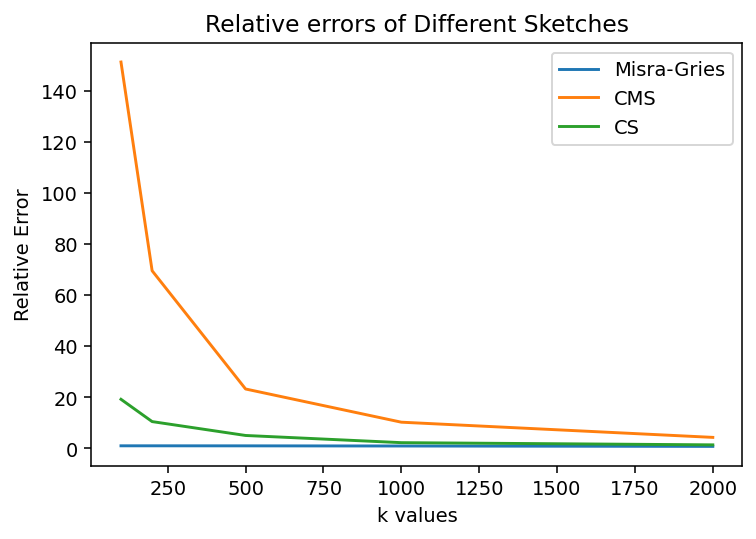

In [44]:
plt.figure(dpi=140)
plt.plot(K, mg_error)
plt.plot(K, cms_error)
plt.plot(K, cs_error)
plt.xlabel("k values")
plt.ylabel("Relative Error")
plt.title("Relative errors of Different Sketches")
plt.legend(["Misra-Gries", "CMS", "CS"])
plt.show()